# Imports

In [485]:
from __future__ import annotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline
pd.options.display.max_columns = None
plt.style.use("ggplot")

In [486]:
df = pd.read_csv('wine-quality.csv')

# Data Preparation

## Check for duplicate rows

In [487]:
df.shape

(6497, 13)

In [488]:
df.duplicated().sum()

1177

In [489]:
df = df.drop_duplicates()
df.shape

(5320, 13)


## Check for missing values

In [490]:
df.isna().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Exploratory Data Analysis

## Basic information about the dataset

In [491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5320 non-null   object 
 1   fixed acidity         5320 non-null   float64
 2   volatile acidity      5320 non-null   float64
 3   citric acid           5320 non-null   float64
 4   residual sugar        5320 non-null   float64
 5   chlorides             5320 non-null   float64
 6   free sulfur dioxide   5320 non-null   float64
 7   total sulfur dioxide  5320 non-null   float64
 8   density               5320 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5320 non-null   float64
 11  alcohol               5320 non-null   float64
 12  quality               5320 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB


In [492]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [493]:
df.describe(include="object")

,type
count,5320
unique,2
top,white
freq,3961


<hr />

## Distribution of each feature

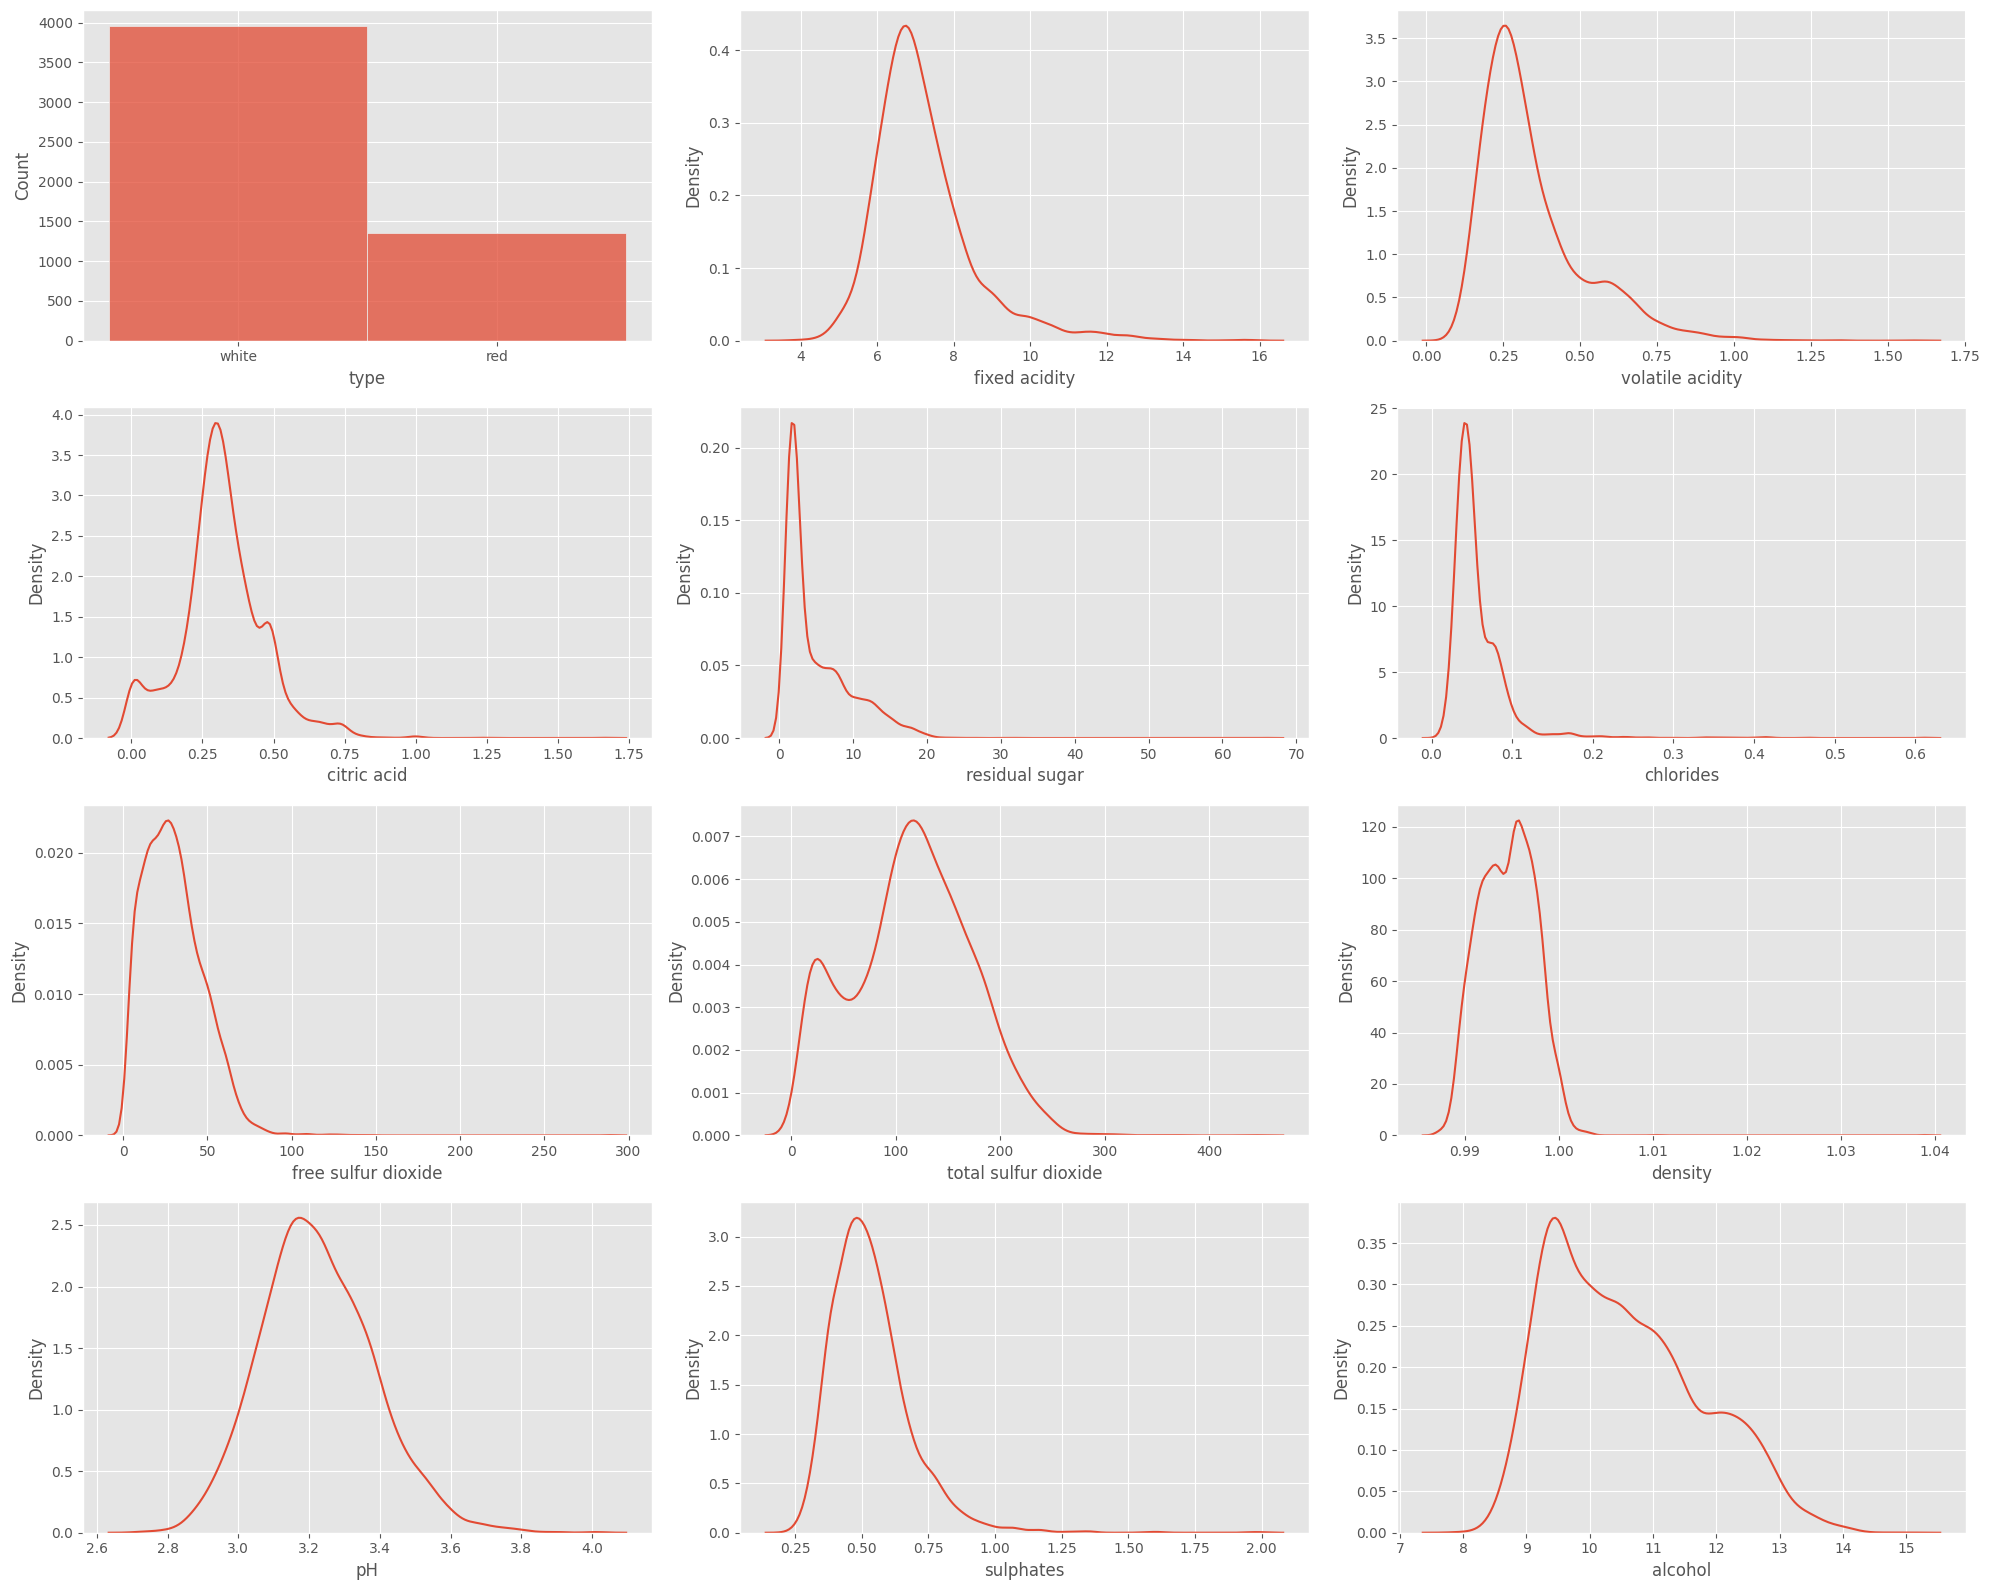

In [494]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0:
        sns.histplot(df.iloc[:, i], ax=ax)
    else:
        sns.kdeplot(df.iloc[:, i], ax=ax)

These histograms tell me that the distribution of the data for all of the skewed to the left. This means that I will need to do some data transformation on the fields I decide to keep, so that the data is more normally distributed.

<hr />

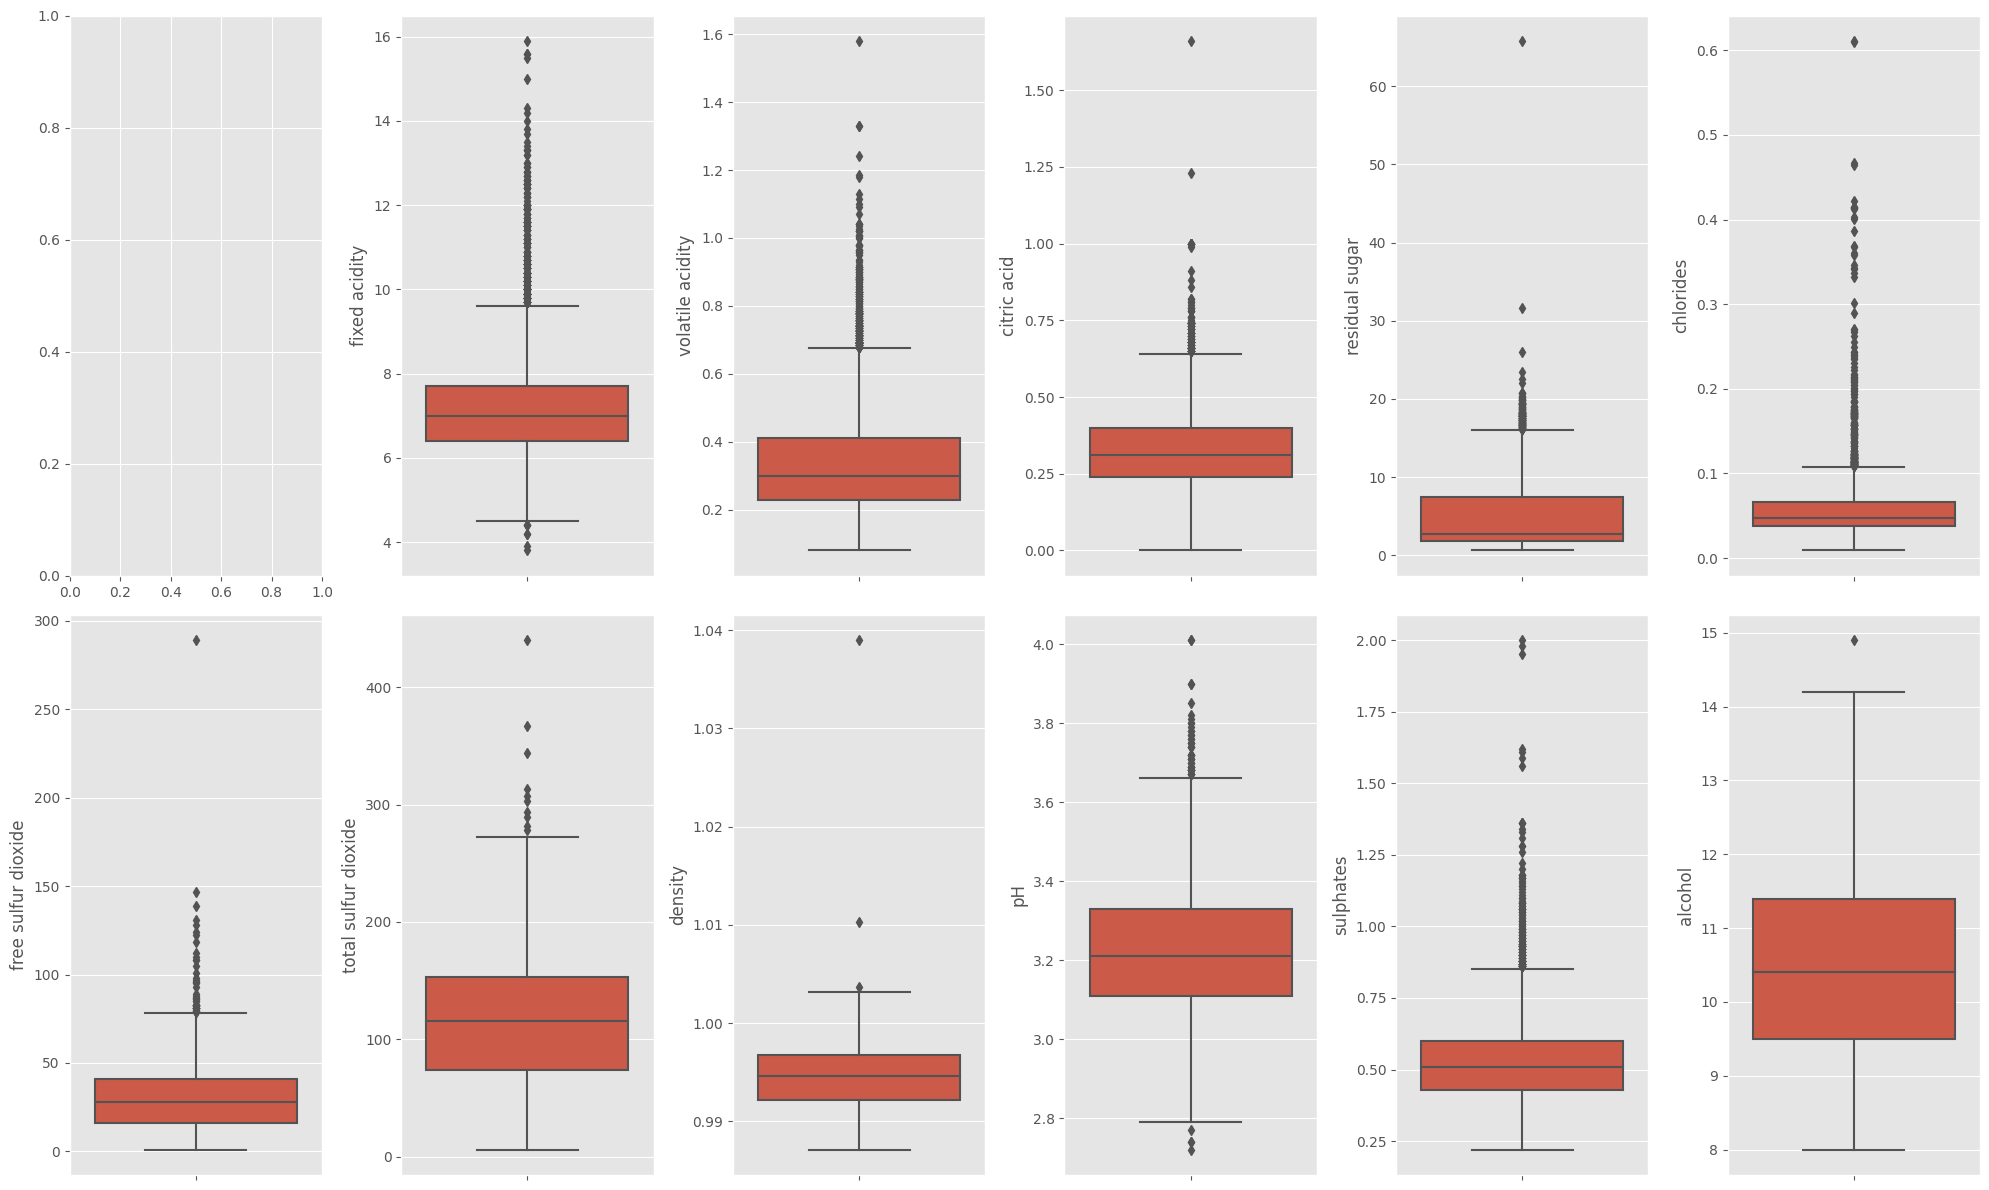

In [495]:
fig, axes = plt.subplots(2, 6, figsize=(20, 12), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0: continue
    sns.boxplot(y=df[df.columns.array[i]], ax=ax)

These boxplots tell me that there are some outliers in the data. I will need to decide if I want to keep these outliers or not.

<hr />

## Handling Outliers

First I want to begin by creating a reusable function to plot the differences between the current feature and the modified feature.

In [496]:
def plot_diff(feature: str):
    """Plot the differences between the original and modified feature columns"""
    global df
    fig, axes = plt.subplots(2, 3, figsize=(20, 12), tight_layout=True)
    sns.histplot(df[feature], ax=axes[0, 0])
    sns.histplot(df[f"{feature} modified"], ax=axes[1, 0])
    sns.boxplot(x=df[feature], ax=axes[0, 1])
    sns.boxplot(x=df[f"{feature} modified"], ax=axes[1, 1])
    sns.kdeplot(df[feature], ax=axes[0, 2])
    sns.kdeplot(df[f"{feature} modified"], ax=axes[1, 2])

def overwrite_original(feature):
    """Overwrite the original feature column with the modified column, then erase the modified column"""
    global df
    df[feature] = df[f"{feature} modified"]
    df = df.drop(columns=[f"{feature} modified"])

<hr />

### fixed acidity

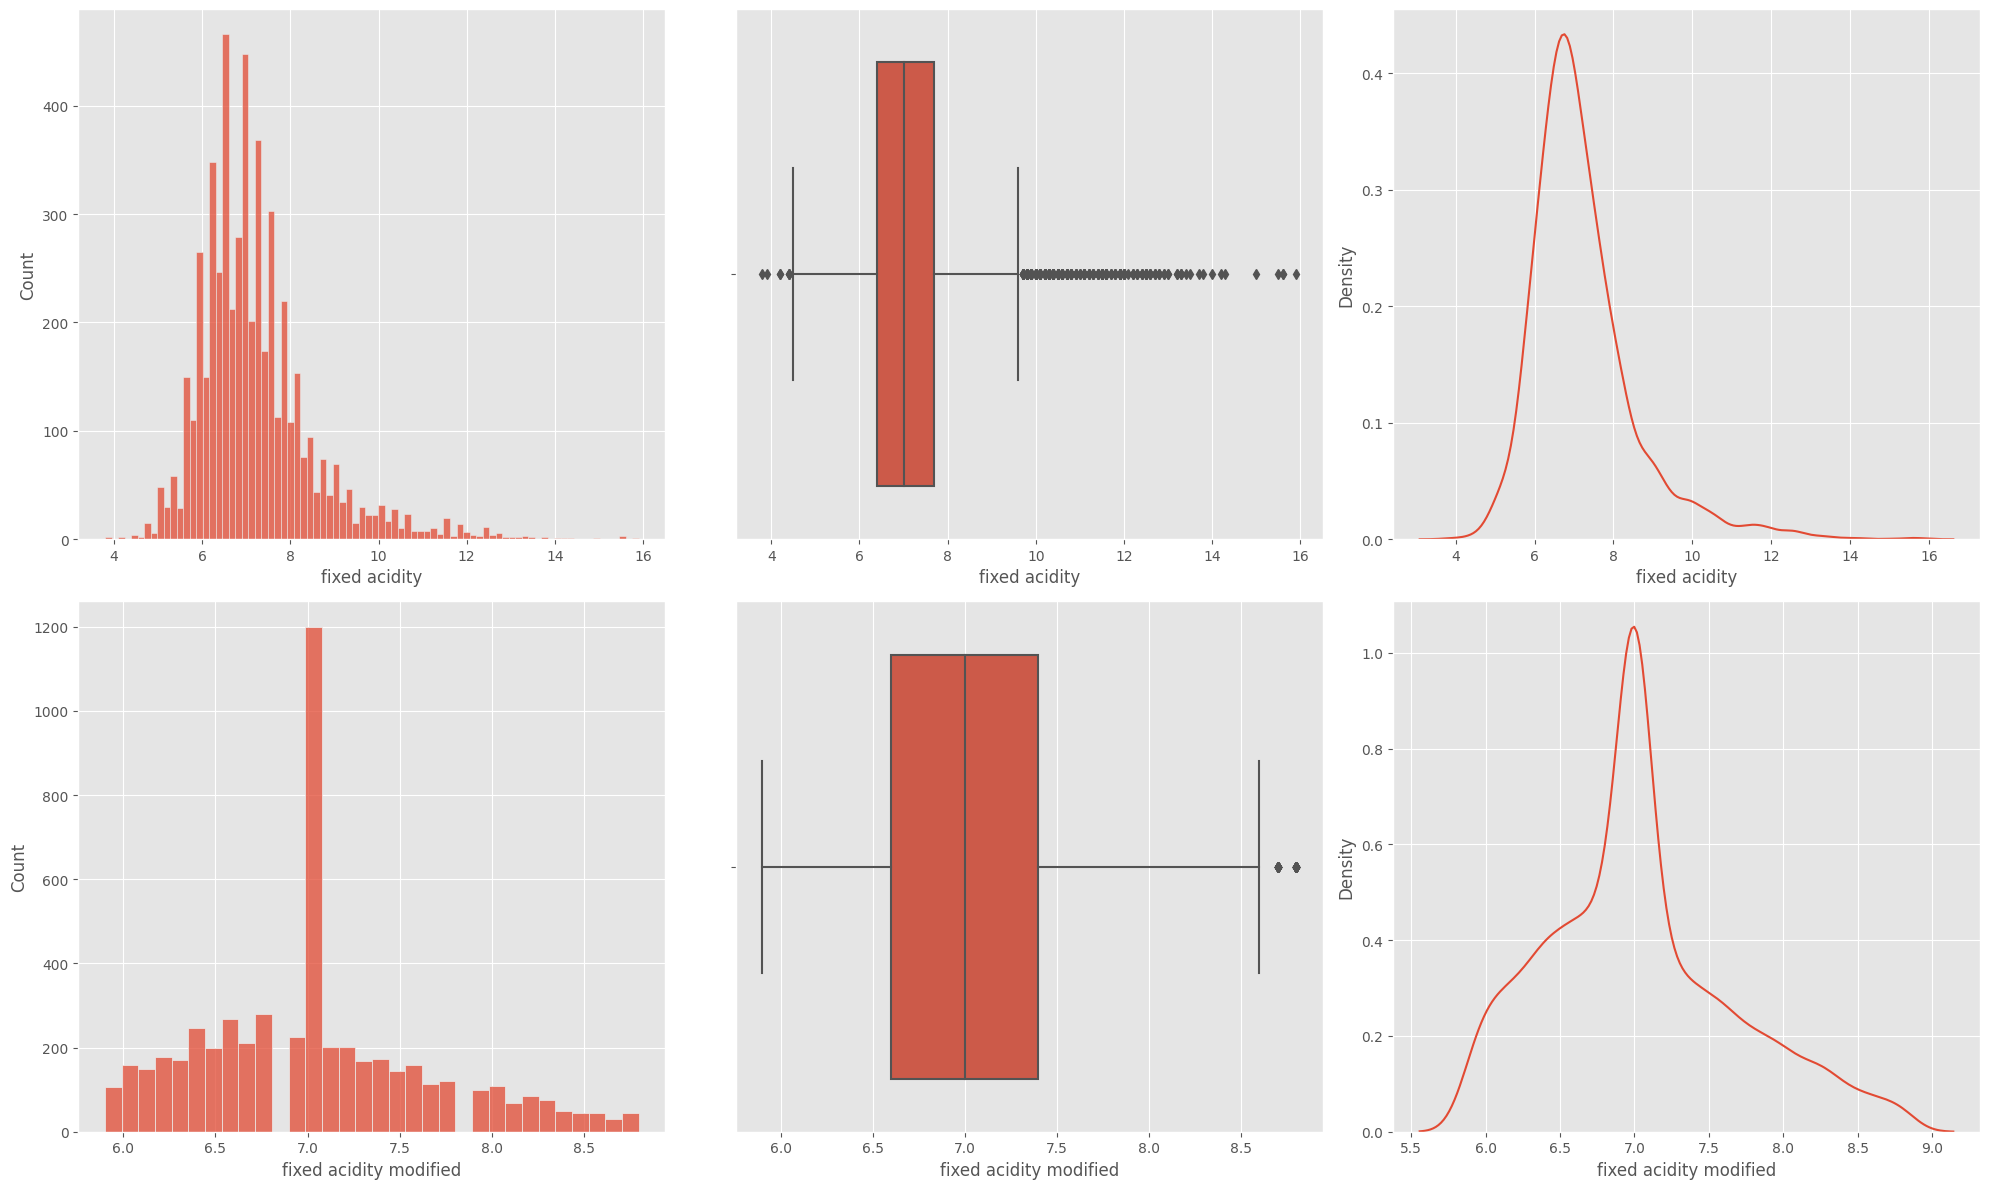

In [497]:
feature = "fixed acidity"

df[f"{feature} modified"] = np.where(
    (df[feature] > df[feature].quantile(0.9)) | (df[feature] < df[feature].quantile(0.1)),
    df[feature].median(),
    df[feature]
)
plot_diff(feature)

What I did here was to replace the extreme outliers (<10th or >90th percentil) with the median value of the feature. Most of the outliers were removed so I think this is a good approach.

In [498]:
overwrite_original(feature)

<hr />

### volatile acidity

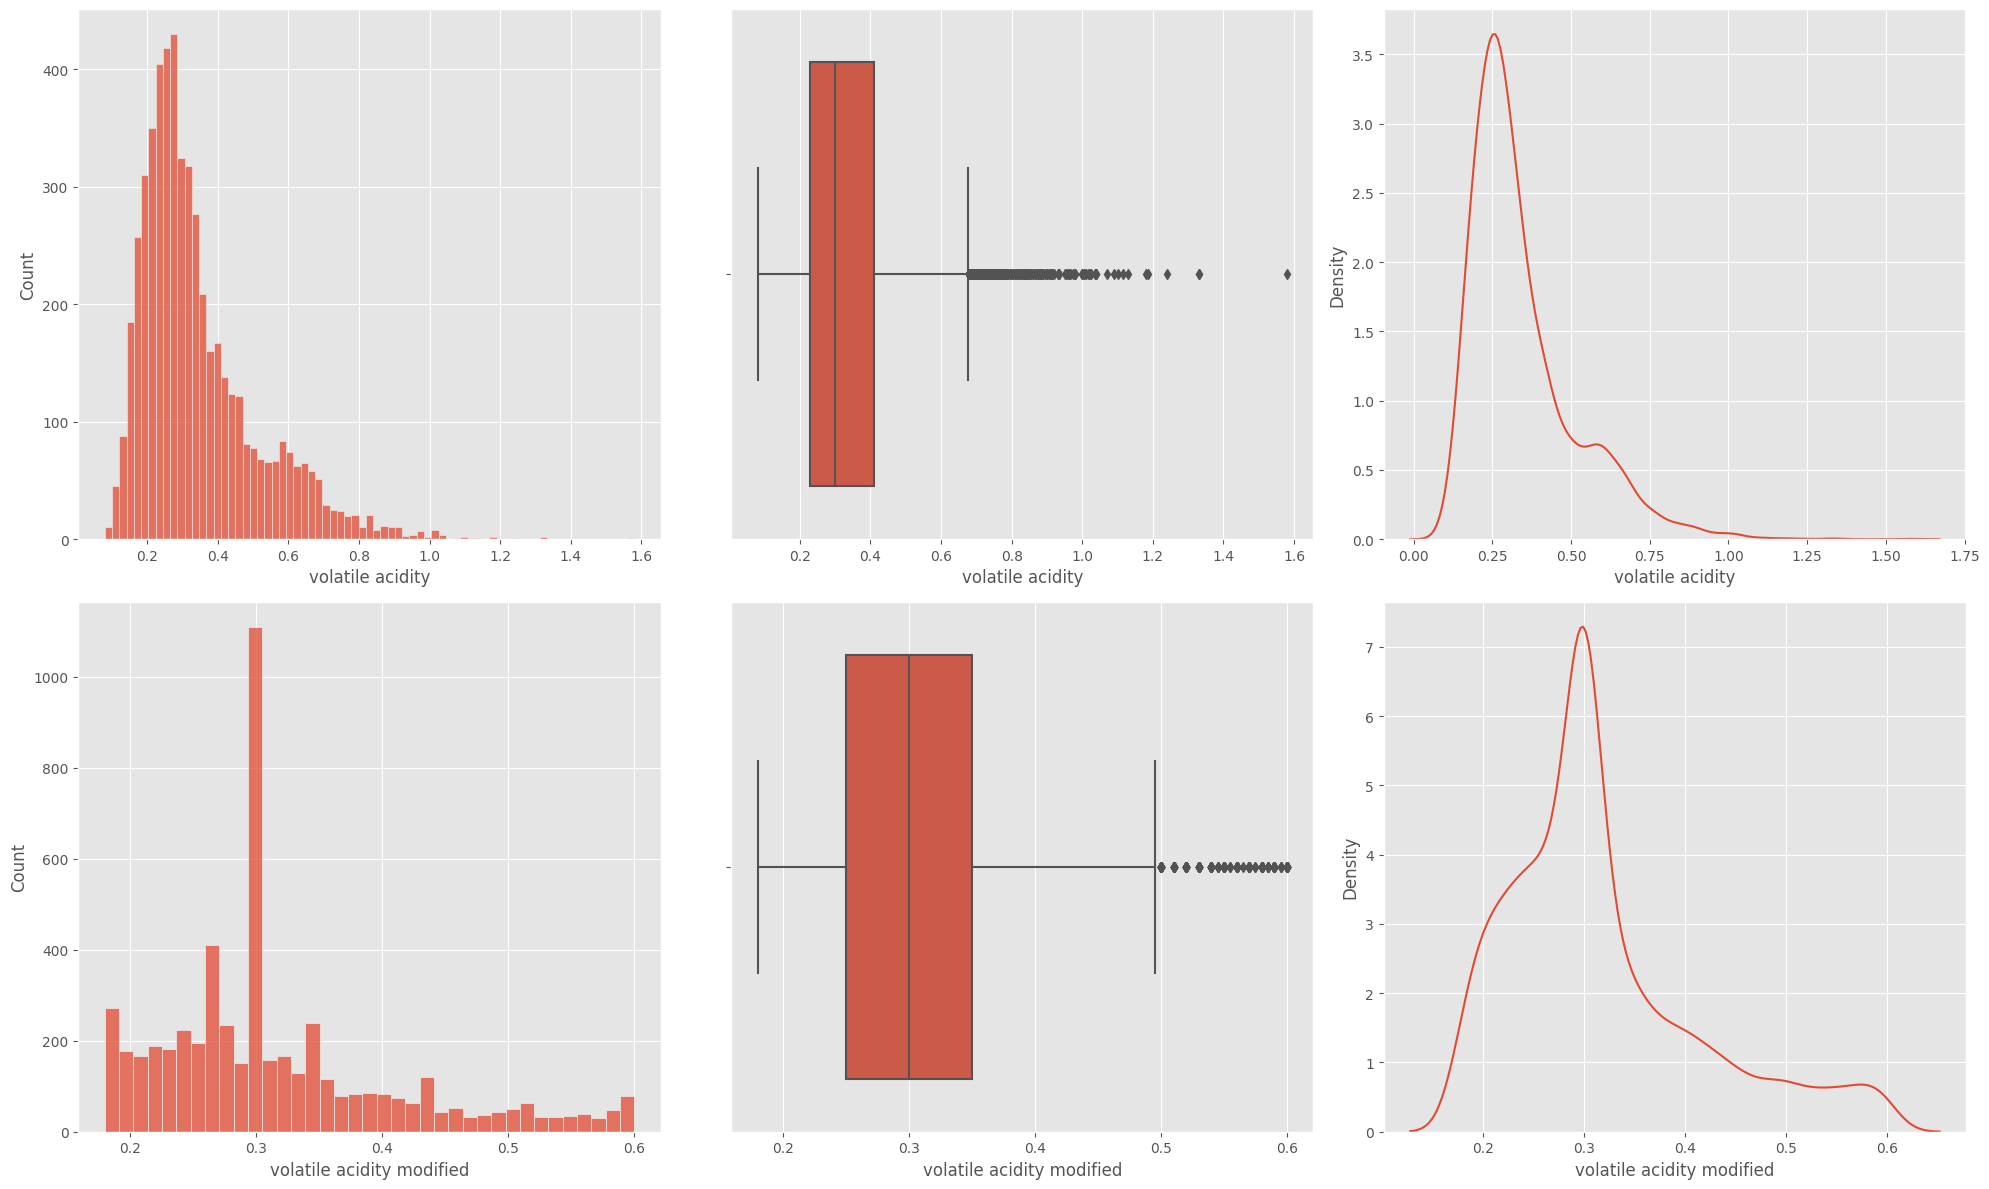

In [499]:
feature = "volatile acidity"

df[f"{feature} modified"] = np.where(
    (df[feature] > df[feature].quantile(0.9)) | (df[feature] < df[feature].quantile(0.1)),
    df[feature].median(),
    df[feature]
)
plot_diff(feature)

Again I replaced the extreme outliers (<10th or >90th percentil) with the median value of the feature.

In [500]:
overwrite_original(feature)

<hr />

### citric acid

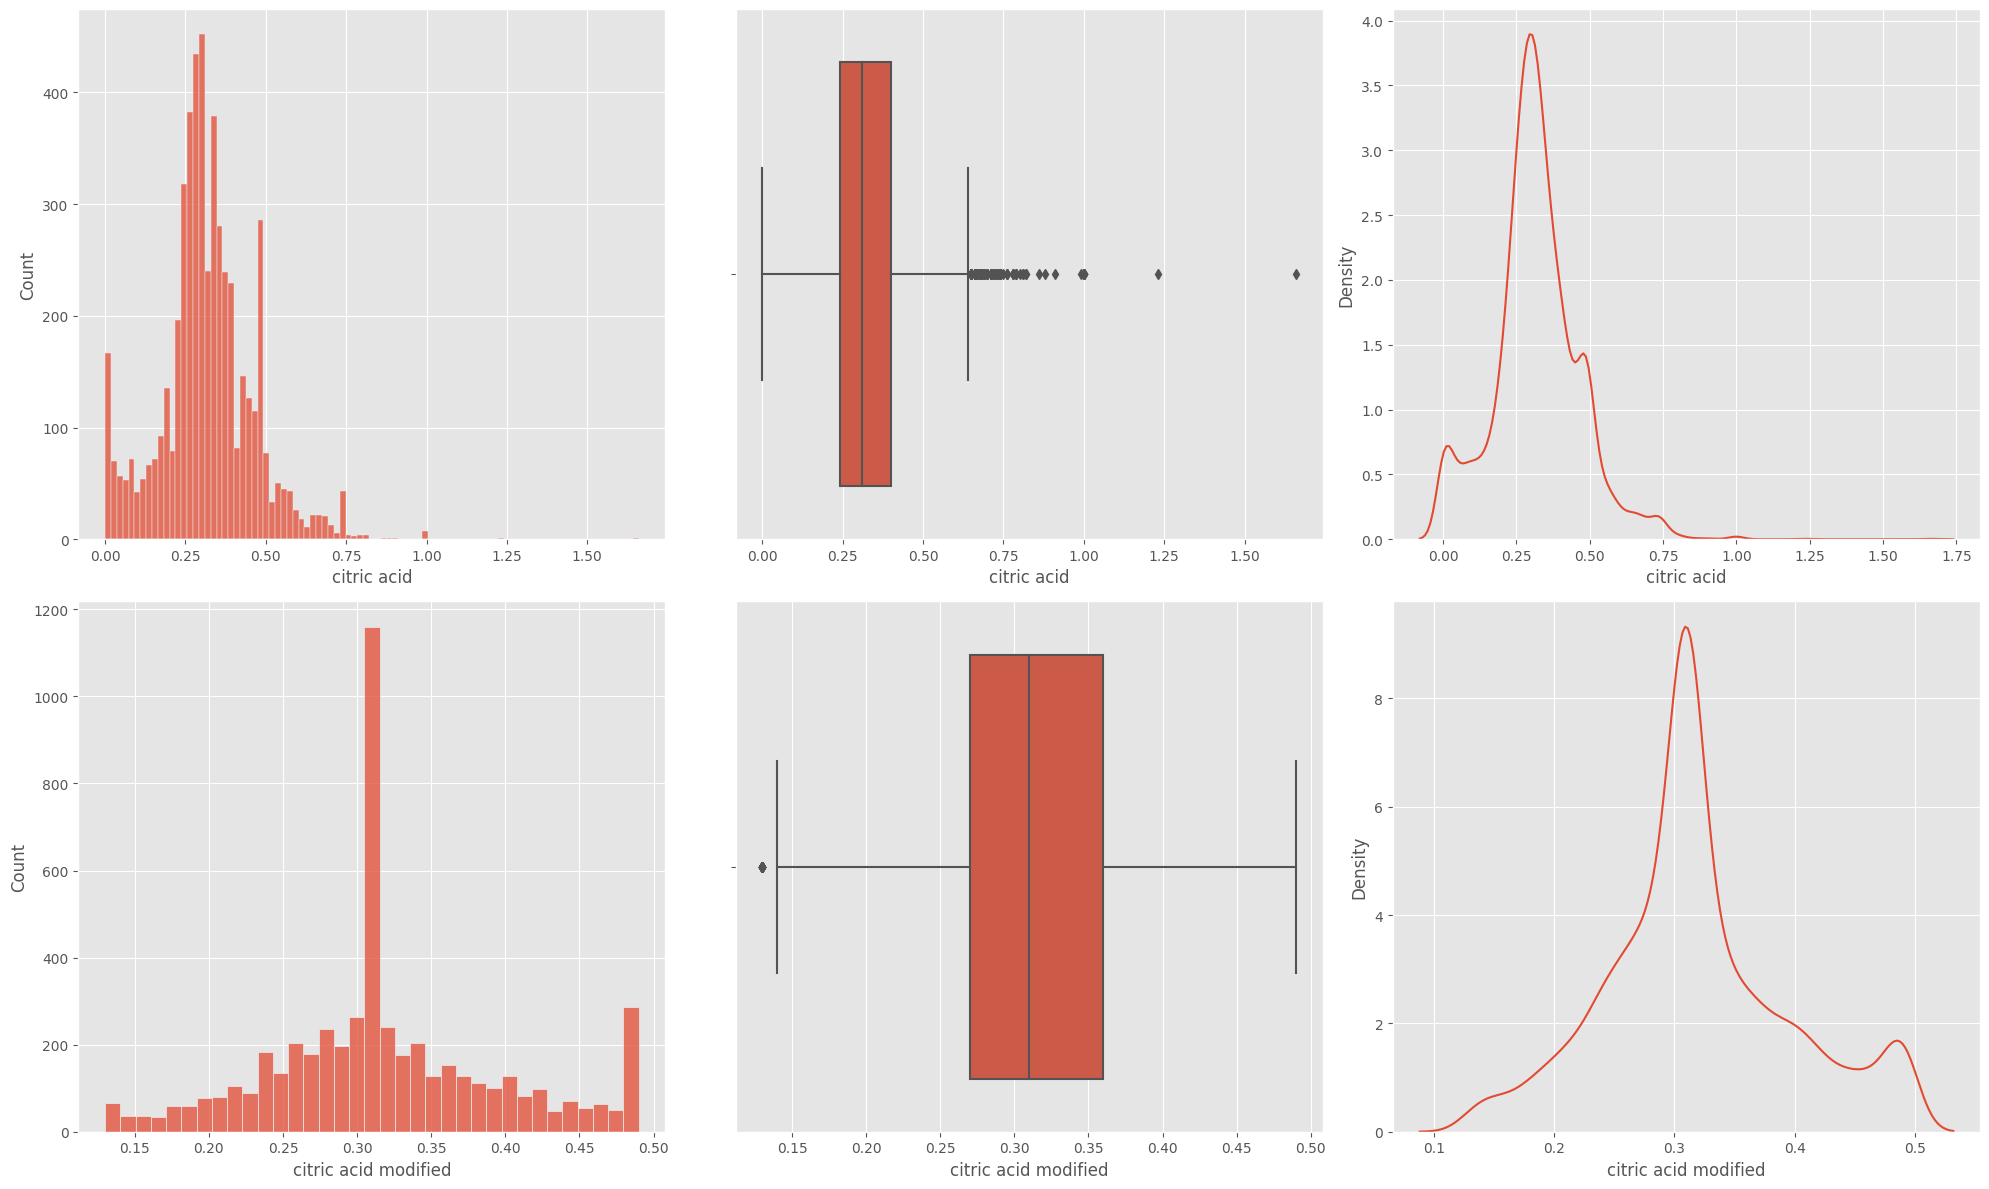

In [501]:
feature = "citric acid"

df[f"{feature} modified"] = np.where(
    (df[feature] > df[feature].quantile(0.9)) | (df[feature] < df[feature].quantile(0.1)),
    df[feature].median(),
    df[feature]
)
plot_diff(feature)

In [ ]:
overwrite_original(feature)

<hr />

### residual sugar

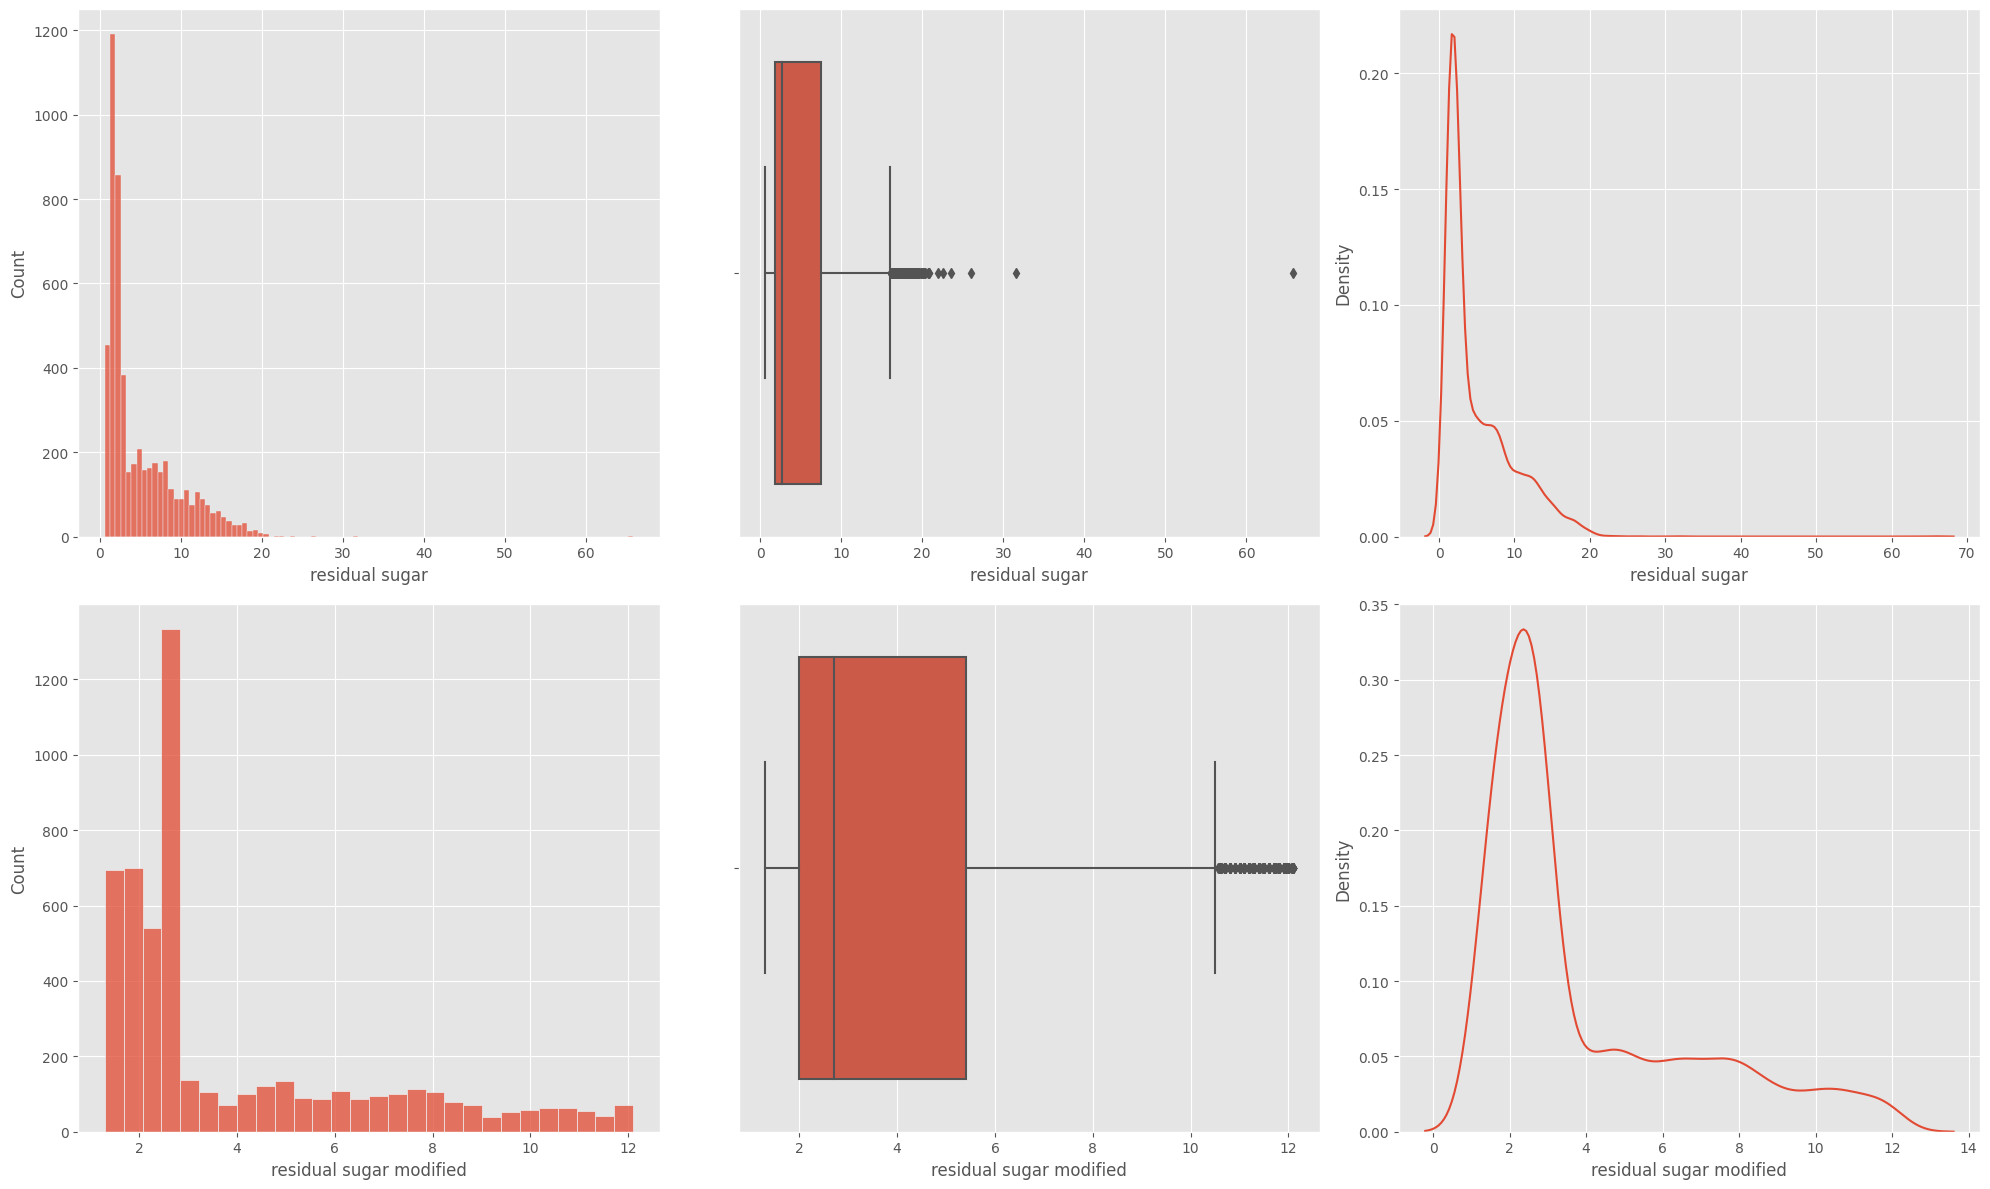

In [510]:
feature = "residual sugar"

df[f"{feature} modified"] = np.where(
    (df[feature] > df[feature].quantile(0.9)) | (df[feature] < df[feature].quantile(0.1)),
    df[feature].median(),
    df[feature]
)
plot_diff(feature)

In [515]:
overwrite_original(feature)

<hr />

If the chlorides in water are above 0.1, then the quality is 0

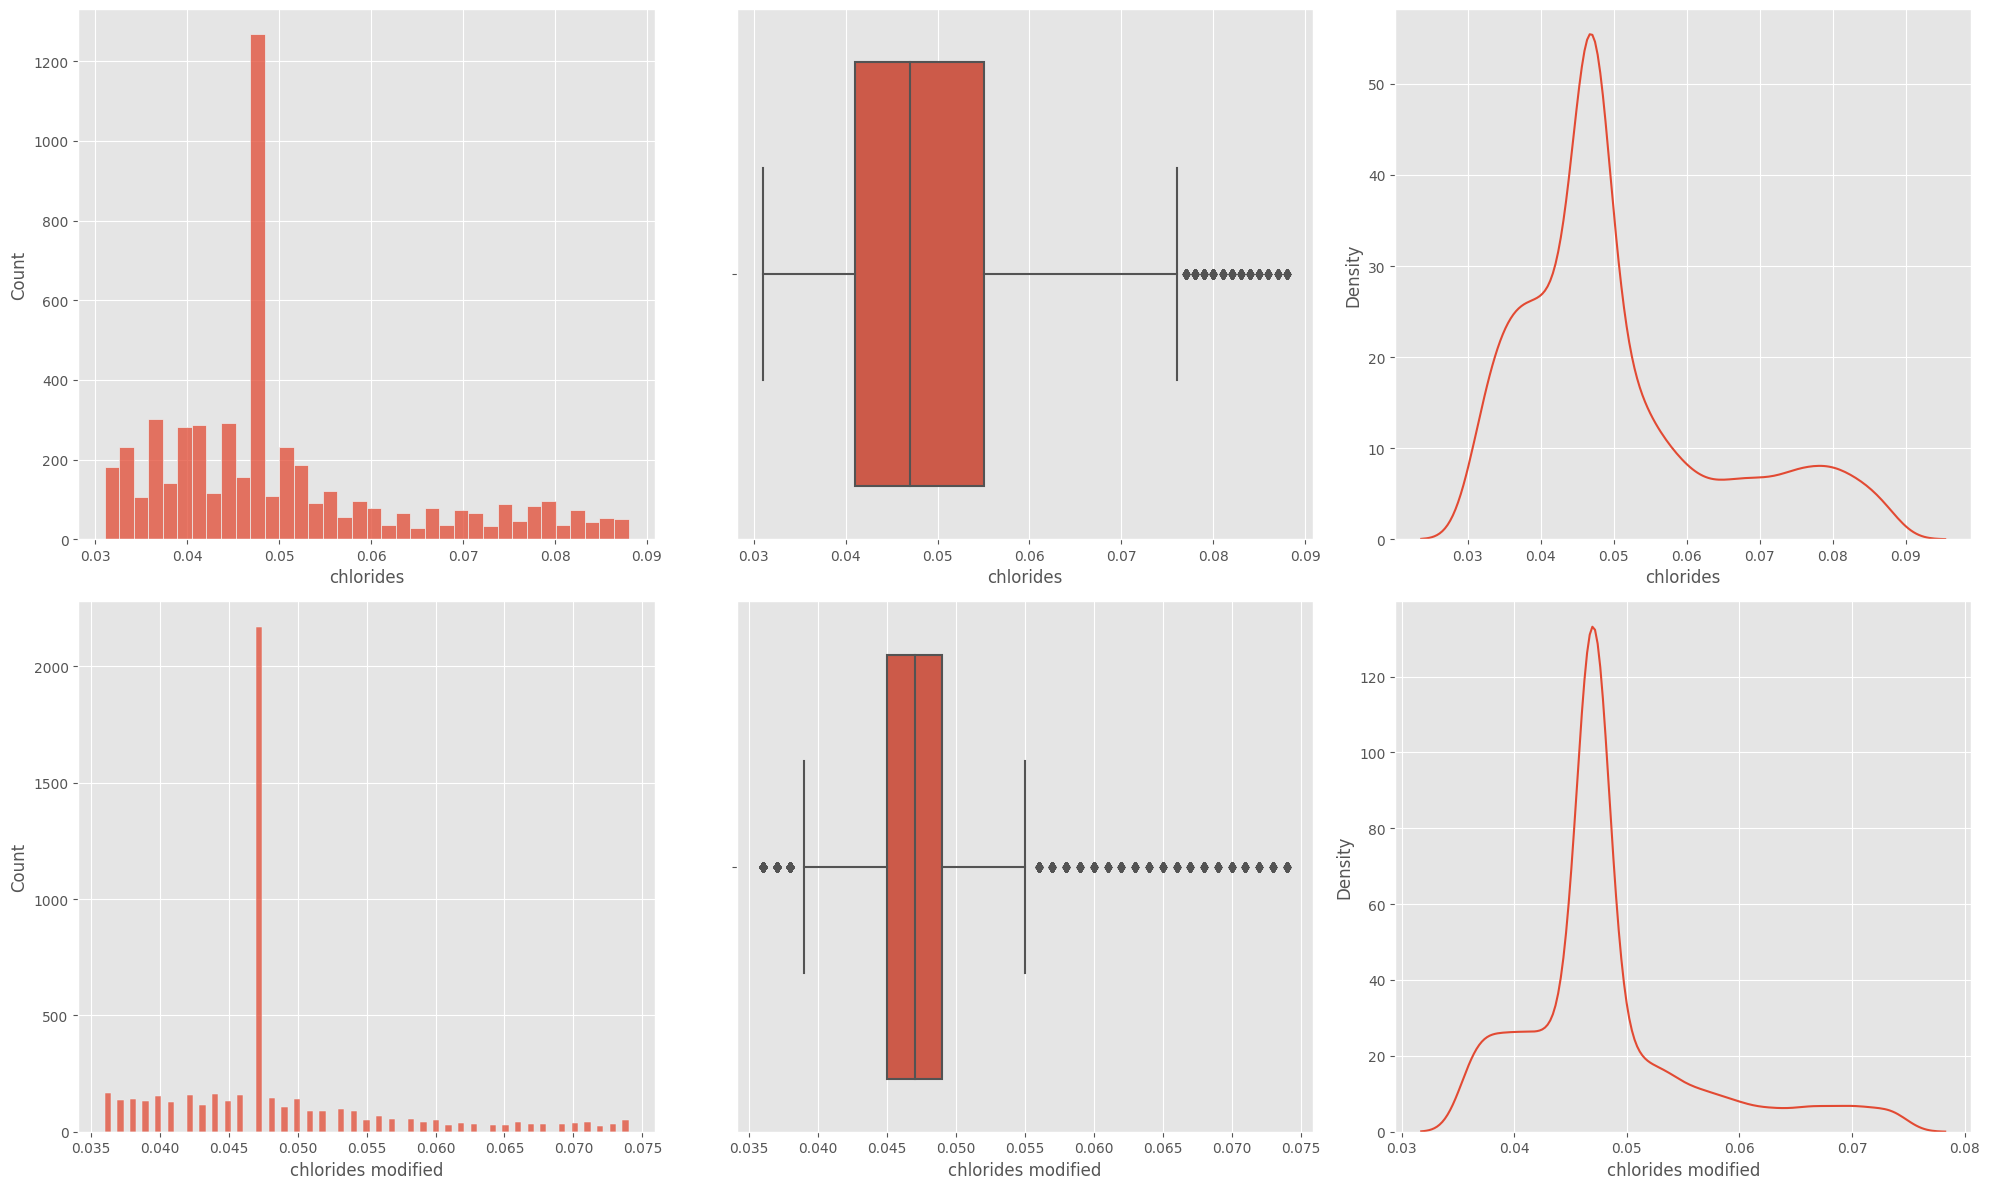

In [516]:
feature = "chlorides"

df[f"{feature} modified"] = np.where(
    (df[feature] > df[feature].quantile(0.9)) | (df[feature] < df[feature].quantile(0.1)),
    df[feature].median(),
    df[feature]
)
plot_diff(feature)

In [ ]:
overwrite_original(feature)

<hr />

### free sulfur dioxide

### total sulfur dioxide

### density

### pH

### sulphates

### alcohol

## Correlation of each feature

<AxesSubplot: >

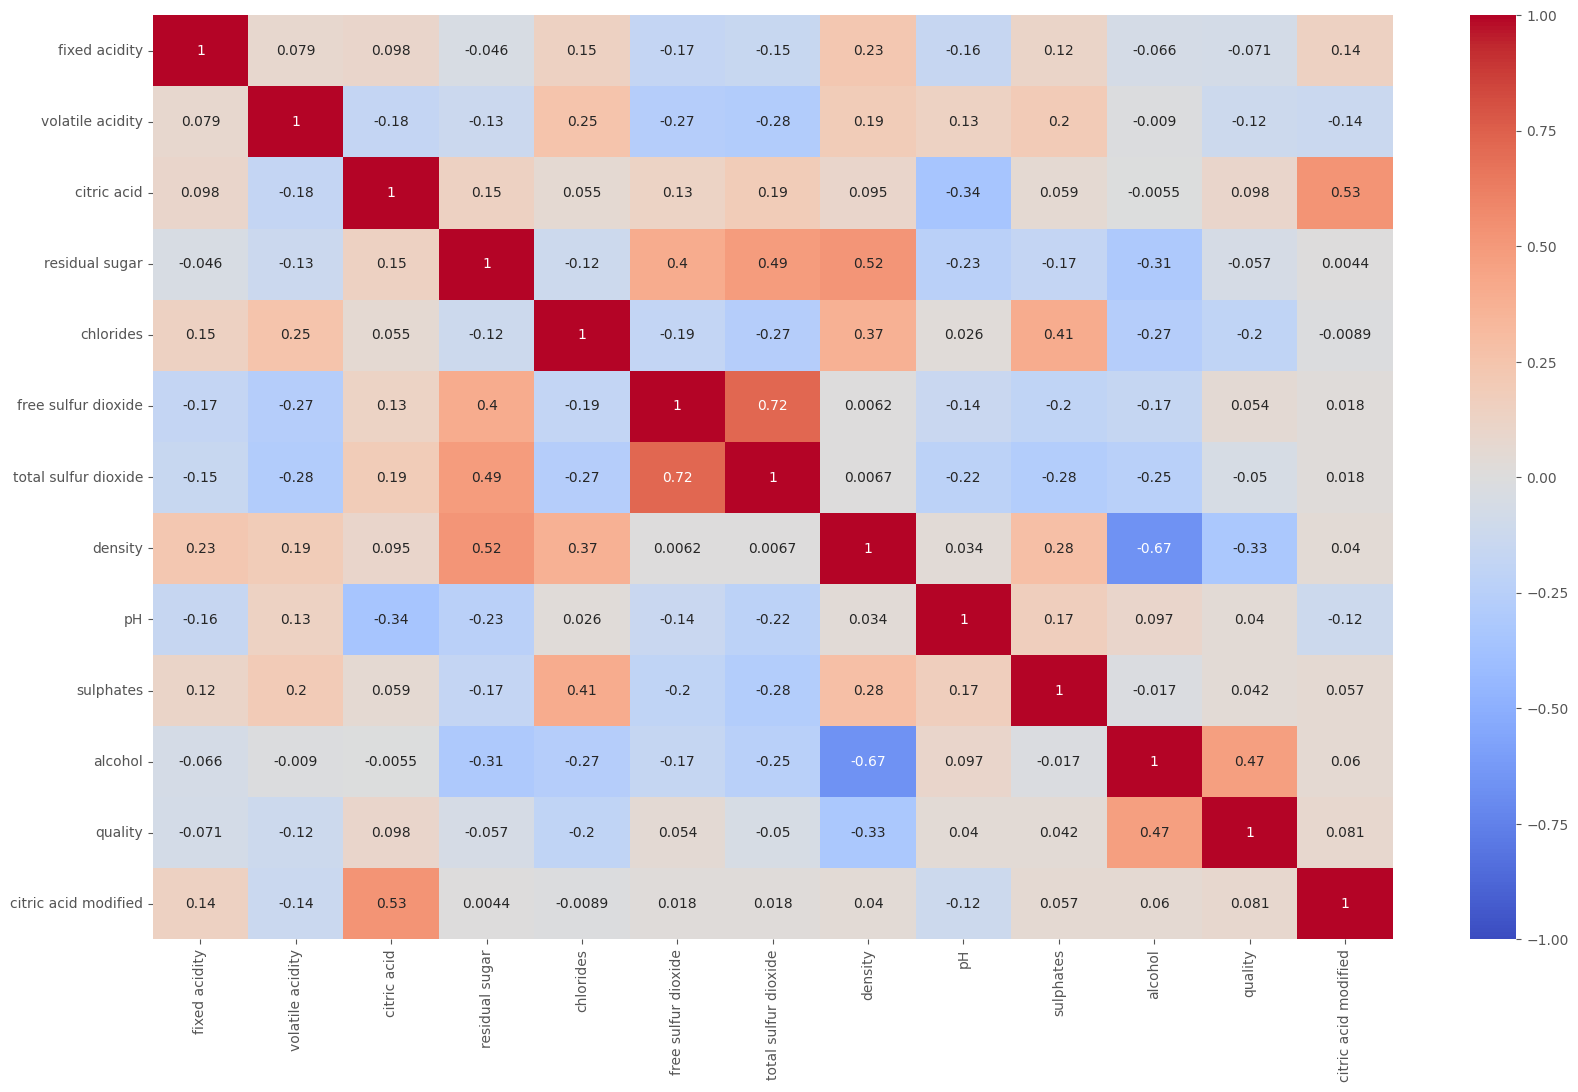

In [502]:
fig, ax = plt.subplots(figsize=(20, 12))

sns.heatmap(
    df.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax,
)

This correlation heatmap tells me that the features have a moderate correlation with each other. This means that I will need to do some feature selection to reduce the number of features I use in my model.

<hr />

## Correlation of each feature with the target

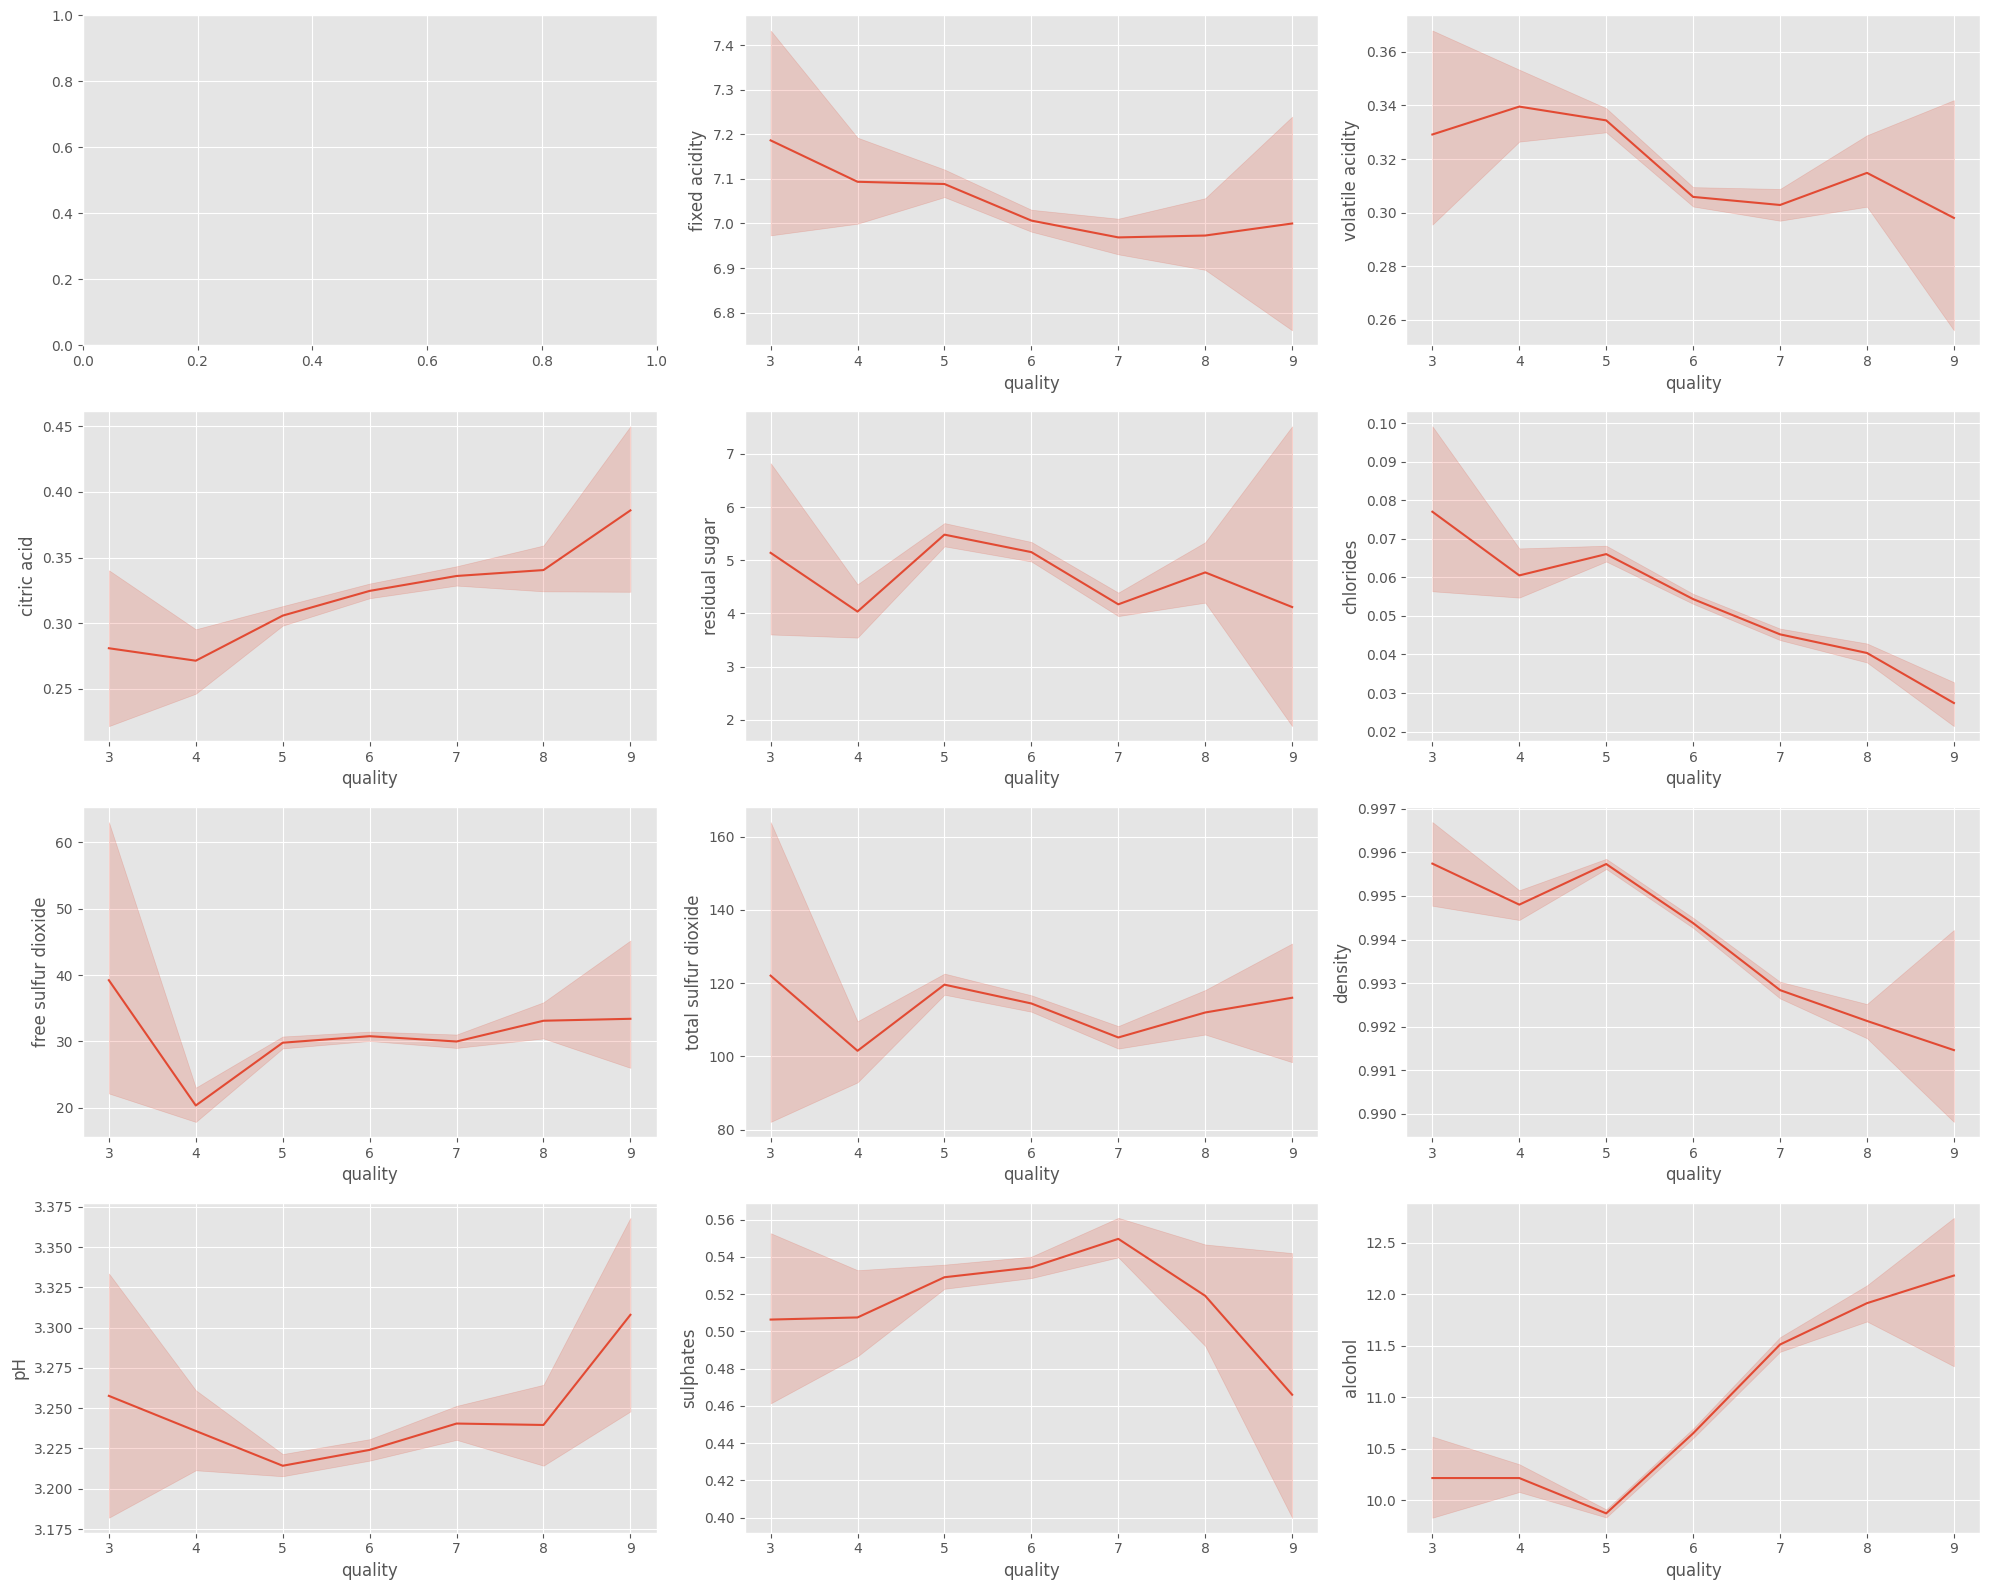

In [503]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 0: continue
    sns.lineplot(df, x="quality", y=df.columns.array[i], ax=ax)

These graphs tell me that some of the features are more likely to affect the quality of the wine than others since the lines are more linear than the others, and can be used to predict the quality of the wine better. These features are `volatile acidity`, `citric acid`, `chlorides`, `density` and `alcohol`

<hr />

# Feature Engineering

## Feature Selection

## Making the Features Normally Distributed

In [504]:
# feature = "volatile acidity"

# df[f"{feature} modified"] = np.log(df[feature])
# fig, axes = plt.subplots(2, 3, figsize=(20, 12), tight_layout=True)
# sns.histplot(df[feature], ax=axes[0, 0])
# sns.histplot(df[f"{feature} modified"], ax=axes[1, 0])
# sns.boxplot(x=df[feature], ax=axes[0, 1])
# sns.boxplot(x=df[f"{feature} modified"], ax=axes[1, 1])
# sns.kdeplot(x=df[feature], ax=axes[0, 2])
# sns.kdeplot(x=df[f"{feature} modified"], ax=axes[1, 2])

## Scaling Important Features

# Model Building

In [505]:
df = pd.get_dummies(df, columns=["type"])

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,citric acid modified,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0.36,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0.34,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0.40,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0.32,0,1
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6,0.16,0,1


In [506]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("quality", axis=1), df["quality"], train_size=0.7, random_state=42)

In [507]:
rfc = RandomForestRegressor(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)

0.37654830601932265